In [1]:
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#importing csv
import pandas as pd
metadata = pd.read_csv("C:\\Users\\LENOVO\\Desktop\\SE\\Project\\train_dataset\\train_data.csv",encoding='unicode_escape')
metadata.head(5)

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,author,primary_label,longitude,length,time,recordist,license,resampled_sampling_rate,resampled_filename,resampled_channels
0,3.5,NaN,amewig,1 (mono),6/2/2013,level,20,XC150015.mp3,level,American Wigeon,...,Dugan Maynard,Mareca americana_American Wigeon,-111.3803,0-3(s),5:00,Dugan Maynard,Creative Commons Attribution-NonCommercial-Sha...,32000,XC150015.wav,1 (mono)
1,3.0,no,amewig,1 (mono),6/9/2013,level,24,XC150063.mp3,level,American Wigeon,...,Dugan Maynard,Mareca americana_American Wigeon,-111.3803,0-3(s),6:00,Dugan Maynard,Creative Commons Attribution-NonCommercial-Sha...,32000,XC150063.wav,1 (mono)
2,1.0,no,amewig,1 (mono),6/8/2013,both,25,XC152348.mp3,level,American Wigeon,...,Dugan Maynard,Mareca americana_American Wigeon,-111.3803,0-3(s),22:00,Dugan Maynard,Creative Commons Attribution-NonCommercial-Sha...,32000,XC152348.wav,1 (mono)
3,3.5,no,amewig,1 (mono),10/20/2013,both,153,XC152396.mp3,level,American Wigeon,...,Thomas G. Graves,Mareca americana_American Wigeon,-120.6205,0-3(s),9:30,Thomas G. Graves,Creative Commons Attribution-NonCommercial-Sha...,32000,XC152396.wav,1 (mono)
4,1.5,no,amewig,1 (mono),6/2/2013,level,18,XC152873.mp3,level,American Wigeon,...,Dugan Maynard,Mareca americana_American Wigeon,-111.3803,0-3(s),5:00,Dugan Maynard,Creative Commons Attribution-NonCommercial-Sha...,32000,XC152873.wav,1 (mono)


In [3]:
print(metadata['ebird_code'].unique())
metadata.shape

['amewig' 'amewoo' 'amtspa' 'annhum' 'astfly' 'baisan' 'baleag' 'balori'
 'banswa' 'barswa' 'bawwar' 'belkin1']


(923, 38)

['amewig' 'amewoo' 'amtspa' 'annhum' 'astfly' 'baisan' 'baleag' 'balori'
 'banswa' 'barswa' 'bawwar' 'belkin1']


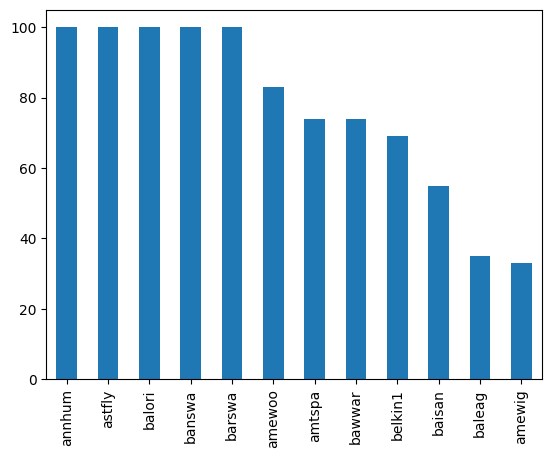

(923, 38)

In [4]:
metadata['ebird_code'].dropna(inplace=True,axis=0)
print(metadata['ebird_code'].unique())
metadata['ebird_code'].value_counts().plot(kind='bar')
plt.show()
metadata.shape

In [3]:
from scipy import signal

def get_mfcc(file_name,mfcc_max_padding=0):
    #load the file (audio)
    y, sample_rate = librosa.load(file_name, res_type='kaiser_best',duration=10)
    #TRIMMING THE LEADING AND TRAILING SILENCE
    # Normalize audio data between -1 and 1
    normalized_y = librosa.util.normalize(y)
    # Compute MFCC coefficients
    mfcc = librosa.feature.mfcc(y=normalized_y, sr=sample_rate, n_mfcc=40)
    # Normalize MFCC between -1 and 1
    normalized_mfcc = librosa.util.normalize(mfcc)
    # Should we require padding
    shape = normalized_mfcc.shape[1]
    if (mfcc_max_padding > 0 & shape < mfcc_max_padding):
            xDiff = mfcc_max_padding - shape
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            normalized_mfcc = np.pad(normalized_mfcc, pad_width=((0,0), (xLeft, xRight)), mode='constant')
    return normalized_mfcc

In [6]:
file_name = os.path.abspath("C:\\Users\\LENOVO\\Desktop\\SE\\Project\\train_dataset\\bulori")+"\\XC177260.wav"
data=get_mfcc(file_name)
data.shape

(40, 431)

In [5]:
file_name = os.path.abspath("C:\\Users\\LENOVO\\Desktop\\SE\\Project\\train_dataset")+"\\aldfly\\XC135459.wav"
data=get_mfcc(file_name)
data.shape

(40, 336)

In [4]:
# Given an numpy array of features, zero-pads each ocurrence to max_padding
def add_padding(features, mfcc_max_padding=174):
    padded = []

    # Add padding
    for i in range(len(features)):
        px = features[i]
        size = len(px[0])
        # Add padding if required
        if (size < mfcc_max_padding):
            xDiff = mfcc_max_padding - size
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            px = np.pad(px, pad_width=((0,0), (xLeft, xRight)), mode='constant')
        
        padded.append(px)

    return padded

In [24]:
# Scales data between x_min and x_max
def scale(X, x_min, x_max, axis=0):
    nom = (X-X.min(axis=axis))*(x_max-x_min)
    denom = X.max(axis=axis) - X.min(axis=axis)
    denom[denom==0] = 1
    return x_min + nom/denom 

In [25]:
y, sr = librosa.load("C:\\Users\\LENOVO\\Desktop\\SE\\Project\\train_dataset\\aldfly\\XC135459.wav")
audio_file, _ = librosa.effects.trim(y)
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))


Audio File: [-2.9613268e-05 -1.6397324e-05 -6.1463498e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] 

Audio File shape: (171649,)


In [33]:
from tqdm import tqdm
# Iterate through all audio files and extract MFCC
features = []
labels = []
frames_max = 0

total_samples = len(metadata)
n_mfcc = 40
resampled_filenames=[]


for index, row in tqdm(metadata.iterrows()):
    file_path = os.path.join(os.path.abspath("C:\\Users\\LENOVO\\Desktop\\SE\\Project\\train_dataset"),str(row["ebird_code"])+'/',str(row["resampled_filename"]))
    class_label = row["ebird_code"]

    # Extract MFCCs (do not add padding)
    mfccs = get_mfcc(file_path, 0)
    
    # Save current frame count
    num_frames = mfccs.shape[1]
    
    # Add row (feature / label)
    features.append(mfccs)
    labels.append(class_label)
    resampled_filenames.append(row['resampled_filename'])
    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames
    
print("Finished: {}/{}".format(index, total_samples))

923it [11:37,  1.32it/s]

Finished: 922/923


In [34]:
padded_features = add_padding(features, frames_max)
# Verify shapes
print("Raw features length: {}".format(len(features)))
print("Padded features length: {}".format(len(padded_features)))
print("Feature labels length: {}".format(len(labels)))
print("FIlenames length: {}".format(len(resampled_filenames)))

Raw features length: 923
Padded features length: 923
Feature labels length: 923
FIlenames length: 923


In [36]:
# Convert features (X) and labels (y) to Numpy arrays
X = np.array(padded_features)
y = np.array(labels)

# Optionally save the features to disk
np.save("train_dataset/X-mfcc", X)
np.save("train_dataset/y-mfcc", y)

**MEL SPECTOGRAM**

In [42]:
# Generates/extracts Log-MEL Spectrogram coefficients with LibRosa 
def get_mel_spectrogram(file_path, mfcc_max_padding=0, n_fft=2048, hop_length=512, n_mels=128):
        # Load audio file
        y, sr = librosa.load(file_path)

        # Normalize audio data between -1 and 1
        normalized_y = librosa.util.normalize(y)

        # Generate mel scaled filterbanks
        mel = librosa.feature.melspectrogram(y=normalized_y, sr=sr, n_mels=n_mels)

        # Convert sound intensity to log amplitude:
        mel_db = librosa.amplitude_to_db(abs(mel))

        # Normalize between -1 and 1
        normalized_mel = librosa.util.normalize(mel_db)

        # Should we require padding
        shape = normalized_mel.shape[1]
        if (mfcc_max_padding > 0 & shape < mfcc_max_padding):
            xDiff = mfcc_max_padding - shape
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            normalized_mel = np.pad(normalized_mel, pad_width=((0,0), (xLeft, xRight)), mode='constant')
        return normalized_mel


In [43]:
# Iterate through all audio files and extract MFCC
features = []
labels = []
frames_max = 0
counter = 0
total_samples = len(metadata)
n_mels=40


for index, row in tqdm(metadata.iterrows()):
    file_path = os.path.join(os.path.abspath("C:\\Users\\LENOVO\\Desktop\\SE\\Project\\train_dataset"),str(row["ebird_code"])+'/',str(row["resampled_filename"]))
    class_label = row["ebird_code"]

    # Extract Log-Mel Spectrograms (do not add padding)
    mels = get_mel_spectrogram(file_path, 0, n_mels=n_mels)
    
    # Save current frame count
    num_frames = mels.shape[1]
    
    # Add row (feature / label)
    features.append(mels)
    labels.append(class_label)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

    # Notify update every N files
    if (counter == 500):
        print("Status: {}/{}".format(index+1, total_samples))
        counter = 0

    counter += 1
    
print("Finished: {}/{}".format(index, total_samples))

501it [33:04,  4.78s/it]

Status: 501/923


923it [1:32:16,  6.00s/it] 

Finished: 922/923


In [44]:
# Add padding to features with less than frames than frames_max
padded_features = add_padding(features, frames_max)
# Verify shapes
print("Raw features length: {}".format(len(features)))
print("Padded features length: {}".format(len(padded_features)))
print("Feature labels length: {}".format(len(labels)))

Raw features length: 923
Padded features length: 923
Feature labels length: 923


In [ ]:
# Convert features (X) and labels (y) to Numpy arrays
X = np.array(padded_features)
y = np.array(labels)

np.save("train_dataset/X-mel_spec", X)
np.save("train_dataset/y-mel_spec", y)